In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import statsmodels

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


for i in [pd, np, scipy, statsmodels, mpl, sns]:
    print(i.__name__, i.__version__)
    
from scipy.stats import norm

pandas 0.25.1
numpy 1.18.5
scipy 1.5.2
statsmodels 0.11.1
matplotlib 3.5.3
seaborn 0.12.2


# 2-8 분산 분석(ANOVA, Analysis of Variance)

서로 다른 범주에 속한 모집단의 평균 $\mu_0, \mu_1, ... \mu_k$ 동일한지 파악합니다.

$H_0$: $\mu_0 = \mu_1 = ... \mu_k$

$H_1$: $\mu_0, \mu_1, ... \mu_k$에서 동일하지 않는 것이 존재한다.


이 때 범주형 변수를 요인(factor)라고 합니다.


분산분석은

범주형를 가변수화 하여 모집단의 평균을 추정하는 선형 회귀 모델의 유의미성을 검정하는 과정과 유사합니다.

선형 회귀 모델에서 다루었던 제곱합의 성질을 통해, 유도했던 F-test를 적용한 것입니다.

> $SST = SSR + SSE$
>
> $F = \frac{SSR / (p - 1)}{SSE / (n - p)} \sim F(p - 1, n - p)$, $p$: 회귀 모델의 모수의 수, $n$: 표본수

이 가설 검정에 응용한 것입니다.

그리고, 분산분석은 선형 회귀 모델의 가정을 따라갑니다. 

- 서로 다른 범주에 모집단들의 분산은 동일 하다. (오차의 분산은 독립 변수와 상관없이 일정해야 합니다.)


- 서로 다른 범주에 모집단은 정규 분포를 따릅니다. (오차는 정규분포를 따라야 합니다.

## 1. 일원분산분석 (Oneway ANOVA)

단일 요인에 대한 분산분석입니다.

데이터셋을 만들어봅니다.

In [2]:
mu = {'A': 0.3, 'B': 0.3, 'C': 0.3}
sig = 0.2
n = {'A': 30, 'B': 25, 'C': 35}

df_ind = pd.concat([
    pd.DataFrame(norm.rvs(loc=mu[i], scale=sig, size=n[i], random_state=123), columns=['X']).assign(factor=i)
    for i in ['A', 'B', 'C']
], axis=0)

In [3]:
mu = {'A': 0.3, 'B': 0.5, 'C': 0.7}
sig = 0.2
n = {'A': 30, 'B': 25, 'C': 35}

df_dep = pd.concat([
    pd.DataFrame(norm.rvs(loc=mu[i], scale=sig, size=n[i], random_state=123), columns=['X']).assign(factor=i)
    for i in ['A', 'B', 'C']
], axis=0)

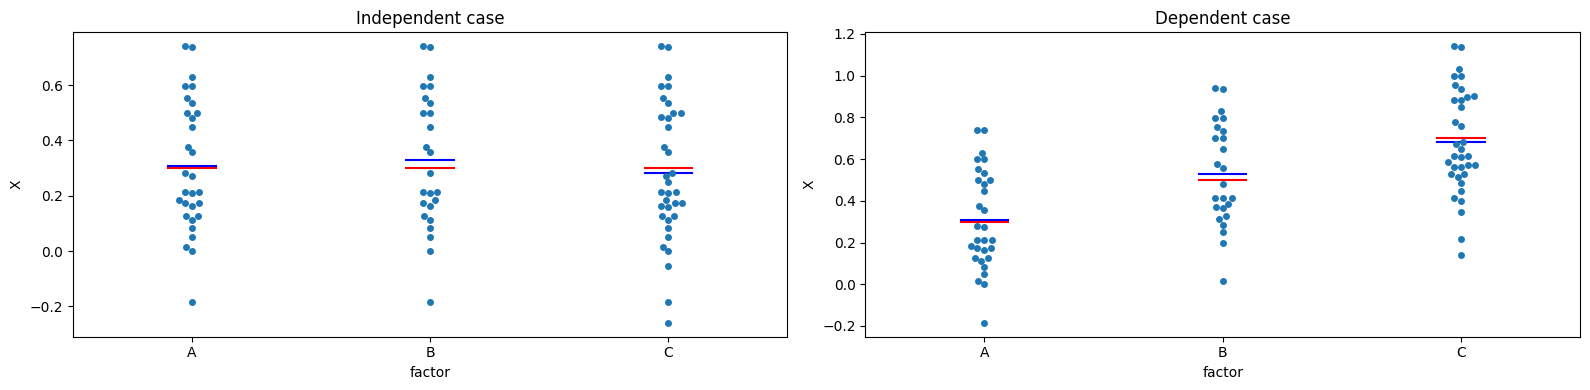

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Independent case')
sns.swarmplot(data=df_ind, x='factor', y='X', ax=axes[0])
for i, c in enumerate(['A', 'B', 'C']):
    x_bar = df_ind.loc[df_ind['factor'] == c, 'X'].mean()
    axes[0].add_line(mlines.Line2D([-0.1 + i, 0.1 + i], [0.3, 0.3], c='r'))
    axes[0].add_line(mlines.Line2D([-0.1 + i, 0.1 + i], [x_bar, x_bar], c='b'))

axes[1].set_title('Dependent case')
sns.swarmplot(data=df_dep, x='factor', y='X', ax=axes[1])
for i, c in enumerate(['A', 'B', 'C']):
    x_bar = df_dep.loc[df_dep['factor'] == c, 'X'].mean()
    axes[1].add_line(mlines.Line2D([-0.1 + i, 0.1 + i], [0.3 + 0.2 * i, 0.3 + 0.2 * i], c='r'))
    axes[1].add_line(mlines.Line2D([-0.1 + i, 0.1 + i], [x_bar, x_bar], c='b'))

plt.tight_layout()
plt.show()

**[Ex.1]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px">

df_ind에서 factor 에 대한 X의 모집단에 대한 분산분석을 합니다.
    
</div>

statsmodel를 통한 방법입니다. 

**statsmodels.formula.api.ols** → **statsmodels.formula.api.anova_lm**

※ ols의 formula(patsy 식) 범주형 변수의 가변수화는 C(변수명)로 표현하면됩니다.

In [5]:
from statsmodels.formula.api import ols
from statsmodels.api import stats
lm = ols('X ~ C(factor)', data=df_ind).fit()
df_anova = stats.anova_lm(lm)
df_anova

,df,sum_sq,mean_sq,F,PR(>F)
C(factor),2.0,0.033030,0.016515,0.275669,0.759725
Residual,87.0,5.212032,0.059908,NaN,NaN


In [6]:
print("검정통계량(F): {}, pvalue: {}".format(df_anova.loc['C(factor)', 'F'], df_anova.loc['C(factor)', 'PR(>F)']))

검정통계량(F): 0.2756692188624851, pvalue: 0.7597245063787699


In [7]:
# 일원분산분석은 선형회귀 모델의 F-test와도 동일한 결과를 냅니다.
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.2757
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.760
Time:                        18:40:14   Log-Likelihood:                0.49333
No. Observations:                  90   AIC:                             5.013
Df Residuals:                      87   BIC:                             12.51
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3089      0.045      6.913      0.000       0.220       0.398
C(factor)[T.B]     0.0191      0.066      0.288      0.774      -0.113       0.151
C(factor)[T.C]    -0.0276      0.061     -0.452      0.652      -0.149       0.093
==============================================================================
Omnibus:                        4.137   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                2.156
Skew:                           0.037   Prob(JB):                        0.340
Kurtosis:                       2.245   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**scipy.stats.f_oneway** 로도 가능합니다.

In [8]:
from scipy.stats import f_oneway
f_oneway(*df_ind.groupby('factor')['X'].agg(list))

F_onewayResult(statistic=0.27566921886248474, pvalue=0.7597245063787699)

$SST = SSR + SSE$

$\sum_{i \in factor}\sum_{j=1}^{n_i}{\left(y_{ij} - \bar{y}\right)^2} = \sum_{i \in factor}\sum_{j=1}^{n_i}{\left(\bar{y_i} - \bar{y}\right)^2} + \sum_{i \in factor}\sum_{j=1}^{n_i}{\left(y_{ij} - \bar{y_{i}}\right)^2}$

**직접 구해봅니다.**

In [9]:
from scipy.stats import f

def ss(v):
    return (v ** 2).sum()

sst = ss(df_ind['X'] - df_ind['X'].mean())
ssr = ss(df_ind.groupby('factor')['X'].transform('mean') - df_ind['X'].mean())
sse = ss(df_ind['X'] - df_ind.groupby('factor')['X'].transform('mean'))
         
df_ssr = df_ind['factor'].nunique() - 1
df_sse = len(df_ind) - df_ind['factor'].nunique()
F = (ssr / df_ssr) / (sse / df_sse)
print("검정통계량(F): {}, pvalue: {}".format(F, f.sf(F, df_ssr, df_sse)))
sst, ssr, sse

검정통계량(F): 0.275669218862485, pvalue: 0.7597245063787699


(5.2450613652543945, 0.03302980845858672, 5.212031556795809)

**[Ex.1]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px">

df_dep에서 categ 에 대한 X의 모집단에 대한 분산분석을 합니다.

분산 분석에 앞서 categ의 범주에 따라 모집단이 정규분포를 따르는지 Kolmogorov-smironof 검정으로 확인하고,

Bartlett 검정을 통해 서로 등분산인지 확인합니다.
    
</div>

In [10]:
from scipy.stats import kstest, zscore
df_dep.groupby('factor')['X'].apply(
    lambda x: pd.Series(kstest(zscore(x, ddof=1), norm.cdf), index=['stat', 'pvalue'])
).unstack()

,stat,pvalue
factor,,
A,0.155033,0.423738
B,0.157950,0.510746
C,0.120307,0.647730


In [11]:
from scipy.stats import bartlett
bartlett(*df_dep.groupby('factor')['X'].agg(list))

BartlettResult(statistic=0.08114650401701767, pvalue=0.9602388225127009)

In [12]:
from scipy.stats import f_oneway
f_oneway(*df_dep.groupby('factor')['X'].agg(list))

F_onewayResult(statistic=18.753725760815882, pvalue=1.6907914024262457e-07)

## 2. 이원분산분석 (Twoway ANOVA)

두 개의 요인에 대한 분산분석입니다.

**상호작용(교호작용)**

두 요인이 작용하여 종속 변수에 미치는 영향이 개별적인 영향의 합으로 설명되지 않는 현상

※ 교호작용은 교호항 마다 두 개이상의 관측치가 있어야 합니다.

교호작용이 존재하는 데이터셋을 만들어 봅니다.

In [13]:
import itertools 
mu = {
    ('A', '1'): 0.2, ('A', '2') : 0.3, ('A','3') : 0.4,
    ('B', '1'): 0.3, ('B', '2') : 0.4, ('B','3') : 0.2
}
sig = 0.2
n = {
    ('A', '1'): 15, ('A', '2') : 25, ('A','3') : 20,
    ('B', '1'): 20, ('B', '2') : 30, ('B','3') : 25
}

df_two = pd.concat([
    pd.DataFrame(norm.rvs(loc=mu[(i, j)], scale=sig, size=n[(i, j)], random_state=123), columns=['X']).assign(factor_1=i, factor_2=j)
    for i,j in itertools.product(['A', 'B'], ['1', '2', '3'])
], axis=0)

교호작용이 있다면,

factor_1와 factor_2 로 구분하여 평균에 대한 그래프를 factor_2의 항목을 x축에 종속 변수의 평균을 y축에, 그리고 factor_1으로 선을 구분하여,

즉 아래와 같이 직선 그래프로 출력하면,

factor_1이 A일 때와 factor_1이 B일 때, factor_2 별 성향이 다르다는 것을 확인 할 수 있습니다.

이렇다면, factor_1과  factor_2의 개별의 평균만으로 설명하기 어렵게 됩니다.

<AxesSubplot:xlabel='factor_2', ylabel='X'>

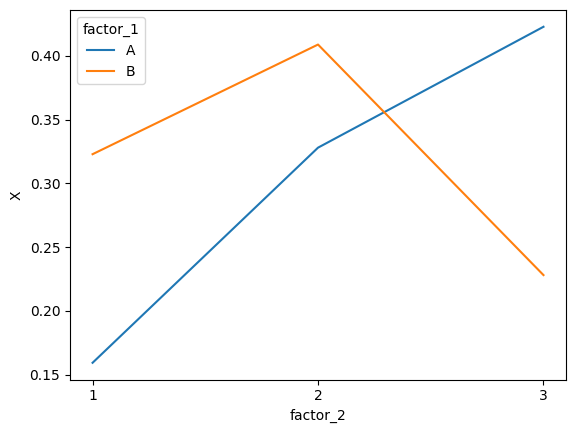

In [14]:
df_two.groupby(['factor_1', 'factor_2'], as_index=False)['X'].mean().pipe(
    lambda x: sns.lineplot(data=x, x='factor_2', y='X', hue='factor_1')
)

**[Ex.2]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px">

df_two에서 X에 대한 factor1, factor2의 이원분산분석을 해봅니다.

statsmodel를 통한 방법입니다. 

※ ols의 formula(patsy 식) 두 범주형 변수의 교호항 가변수화는 C(변수명1):C(변수명2)로 표현하면됩니다.

In [15]:
lm = ols('X ~ C(factor_1) + C(factor_2) + C(factor_1):C(factor_2)', data=df_two).fit()
df_anova = stats.anova_lm(lm)
df_anova

,df,sum_sq,mean_sq,F,PR(>F)
C(factor_1),1.0,0.002269,0.002269,0.038022,0.845706
C(factor_2),2.0,0.309988,0.154994,2.597120,0.078379
C(factor_1):C(factor_2),2.0,0.737363,0.368682,6.177722,0.002741
Residual,129.0,7.698618,0.059679,NaN,NaN


$SSR$ 은 아래와 같이 $SSR_{factor_1}, SSR_{factor_2}, SSR_{factor_1, factor2}$로 분해가 될 수 있습니다.

$SST = SSR_{factor_1} + SSR_{factor_2} + SSR_{factor_1, factor_2} + SSE$

$n_1$: factor1의 요인 수, $n_2$: factor2이 요인 수 라면,

교호항의 가변수를 추가 할 때에는,

> 각 범주형 변수에서 하나의 범주씩을 제외한 순서쌍으로 가변수를 만들어야 완전한 다중공선성을 피할 수 있습니다.
>
> 따라서 $(n_1 - 1)(n_2 - 1)$ 교호항에 대한 가변수가 추가됩니다. 

SSR의 자유도는 $n_1n_2 - 1$  입니다. 

$SSR_{factor_1}$의 자유도는 $n_1 - 1$, $SSR_{factor_2}$의 자유도는 $n_2 - 1$이므로

$SSR_{factor_1, factor_2}$의 자유도는 $n_1n_2 - 1 - n_1 + 1 - n_2 + 1 = (n_1 -1)(n_2 - 1)$ 이 됩니다.

In [16]:
from scipy.stats import f

def ss(v):
    return (v ** 2).sum()

X_bar = df_two['X'].mean()
sst = ss(df_two['X'] - X_bar)

X_prd = df_two.groupby(['factor_1', 'factor_2'])['X'].transform('mean')
ssr = ss(X_prd - X_bar)
ssr_1 = ss(df_two.groupby('factor_1')['X'].transform('mean') - X_bar)
ssr_2 = ss(df_two.groupby('factor_2')['X'].transform('mean') - X_bar)
ssr_12 = ssr - ssr_1 - ssr_2

sse = ss(df_two['X'] - X_prd)

In [17]:
n1 = df_two['factor_1'].nunique()
n2 = df_two['factor_2'].nunique()
df_ssr_12 = (n1 - 1) * (n2 - 1)
df_sse = len(df_two) - n1 * n2
F = (ssr_12 / df_ssr_12) /  (sse / df_sse)
F

6.188013525470501